<a href="https://colab.research.google.com/github/Surajpatra700/Potato_Leaf_Prediction/blob/main/Potato_Leaf_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3
EPOCHS=20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/datasets/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2157 files belonging to 3 classes.


dataset contains 68 batchs with each batches containing pack of 32 images(batch_image & labels)

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

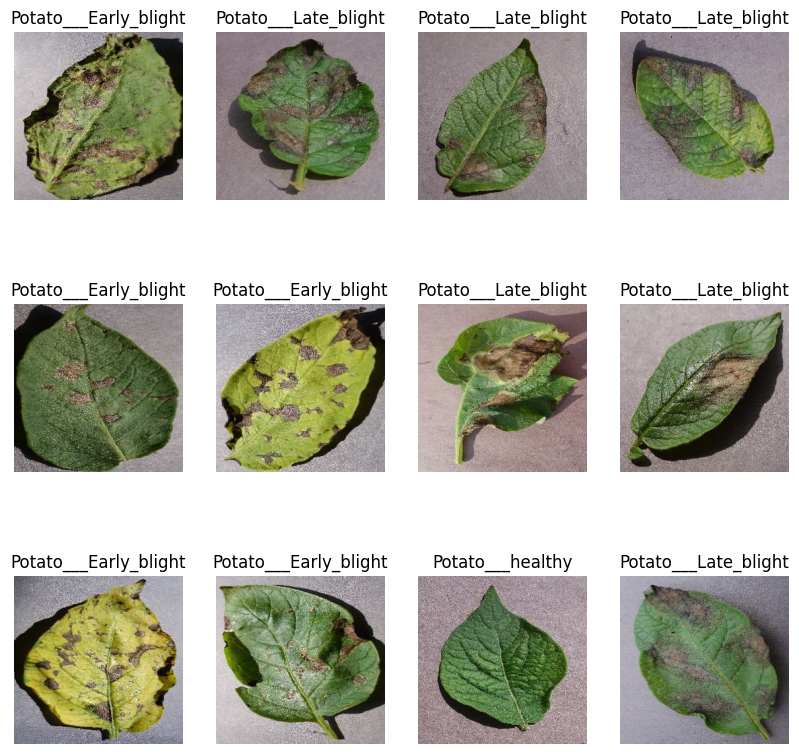

In [6]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
  # print(image_batch.shape)
  # print(label_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[i]])

In [7]:
len(dataset)

68

In [8]:
#  80% --> training
#  20% --> 10% validation, 10% test

In [9]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54) # it will skip 1st 54 dataset
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(len(ds) * train_split)
  val_size = int(len(ds) * val_split)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
#  Pipelining 3 function into 1
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [21]:
#  Model Building

input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNEL)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/20
54/54 [==============================] - 431s 4s/step - loss: 0.9183 - accuracy: 0.5035 - val_loss: 0.8765 - val_accuracy: 0.4583
Epoch 2/20
54/54 [==============================] - 258s 5s/step - loss: 0.7979 - accuracy: 0.6534 - val_loss: 0.8933 - val_accuracy: 0.6354
Epoch 3/20
54/54 [==============================] - 240s 4s/step - loss: 0.5093 - accuracy: 0.7934 - val_loss: 0.4139 - val_accuracy: 0.8490
Epoch 4/20
54/54 [==============================] - 236s 4s/step - loss: 0.3668 - accuracy: 0.8553 - val_loss: 0.3070 - val_accuracy: 0.8854
Epoch 5/20
54/54 [==============================] - 228s 4s/step - loss: 0.3045 - accuracy: 0.8733 - val_loss: 0.2858 - val_accuracy: 0.9010
Epoch 6/20
54/54 [==============================] - 241s 4s/step - loss: 0.2418 - accuracy: 0.9074 - val_loss: 0.1520 - val_accuracy: 0.9427
Epoch 7/20
54/54 [==============================] - 261s 5s/step - loss: 0.1741 - accuracy: 0.9375 - val_loss: 0.1600 - val_accuracy: 0.9375
Epoch 8/20
54

In [26]:
model.evaluate(test_ds)

8/8 [==============================] - 16s 1s/step - loss: 0.2100 - accuracy: 0.9141


[0.20999807119369507, 0.9140625]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
history.history["accuracy"]

[0.5034722089767456,
 0.6533564925193787,
 0.7934027910232544,
 0.8553240895271301,
 0.8732638955116272,
 0.9074074029922485,
 0.9375,
 0.9346064925193787,
 0.9403935074806213,
 0.9265046119689941,
 0.9322916865348816,
 0.9363425970077515,
 0.9560185074806213,
 0.9496527910232544,
 0.9484953880310059,
 0.9525462985038757,
 0.9479166865348816,
 0.9589120149612427,
 0.9444444179534912,
 0.9623842835426331]

In [31]:
acc =history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss= history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Loss')

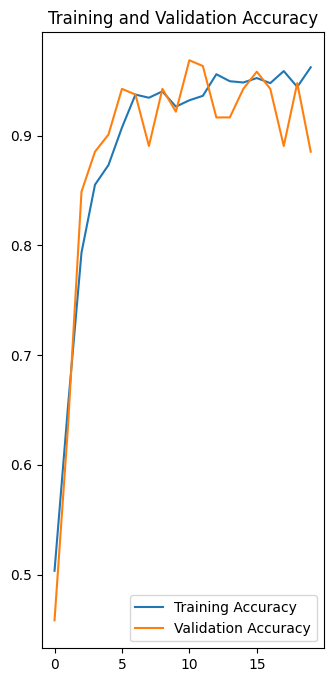

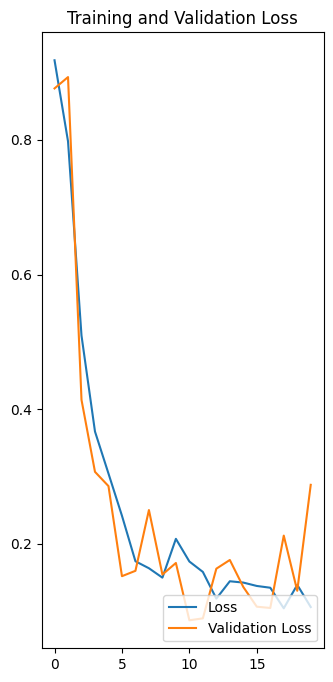

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label="Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")

Image Prediction
Actual label:  Potato___Early_blight
1/1 [==============================] - 3s 3s/step
predicted label:  Potato___Early_blight


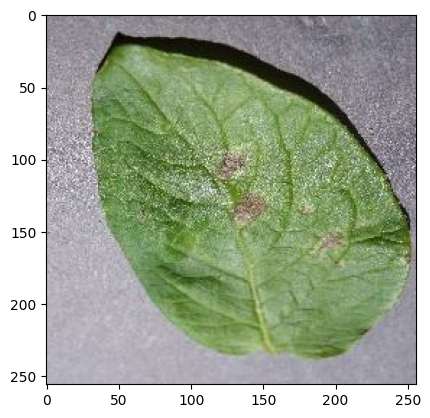

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype("uint8")
  first_label = labels_batch[0].numpy()

  print("Image Prediction")
  plt.imshow(first_image)
  print("Actual label: ",class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label: ",class_names[np.argmax(batch_prediction[0])])

NameError: ignored

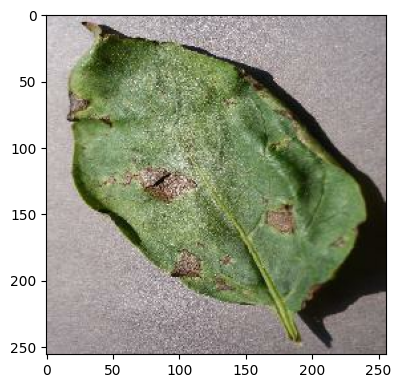

In [38]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy()) # <==> model.predict(images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")

In [ ]:
model_versions = 1
model.save(f"/content/drive/MyDrive/datasets/{model_versions}")